In [1]:
import matplotlib.pyplot as plt
import numpy as np
from lib.PSD.LISAcalPSD import LISAcalPSD1, LISAcalPSD2 
from pycbc.types.frequencyseries import FrequencySeries
import pycbc.psd
from scipy.interpolate import interp1d                   # interplate
from scipy import signal

# 参数设置

In [2]:
sampFreq = 0.25               #采样频率(Sampling frequency)，单位时间样本点个数，应大于 2f（即Nyquist频率)
duration = 2**16          #信号持续时间(duration of signal)


n = int(duration * sampFreq)#采样点数(Sampling Number), 有时也称为信号长度(Length of Signal)
                            #为2的幂时，快速傅里叶变化效率最高
                            #n =  duration * sampFreqint = (duration / sampIntrvl)

sampIntrvl = 1.0 / sampFreq                   #采样周期(Sampling period)，隔多少时间取样一次，或步长
freqIntrvl = sampFreq / n                     #傅里叶变换 频率分辨率(Frequency Interval) 
                                              # freqIntrvl = 1 / duration = 1 / (n * sampIntrvl)
                                              #            = sampFreq / n  
        

f_max = sampFreq/2.0             #信号模式的最大频率

print("采样频率为%3.2fHz，信号持续时间%ds, 时域信号采样%d 个点"%(sampFreq,duration,n))
print("信号中可分析最大频率为%fHz"%f_max)
print("\n采样周期，即时域分辨率为%fs"%(sampIntrvl))
print("信号频域的频率间隔，即频域分辨率为%fHz"%freqIntrvl);

采样频率为0.25Hz，信号持续时间65536s, 时域信号采样16384 个点
信号中可分析最大频率为0.125000Hz

采样周期，即时域分辨率为4.000000s
信号频域的频率间隔，即频域分辨率为0.000015Hz


# 构建用于pyCBC的PSD频率序列

## 利用psd模拟函数生成

In [3]:
freqVec = np.linspace(0, freqIntrvl * (n-1), n)
low_freq_cutoff0 = 1e-4


#构建频率序列(必须等频率间隔)，这里我们开始于0Hz(必须开始于0，否则导入pyCBC的结果不对), 结束于1Hz，频率间隔为上面的freqIntrvl

#LISA PSD 模拟函数
psd1 = LISAcalPSD1(freqVec) 

'''
1. Babak, S., Fang, H., Gair, J. R., Glampedakis, K. & Hughes, S. A. Kludge’
gravitational waveforms for a test-body orbiting a Kerr black hole. Phys.Rev. D 75, 024005 (2007).

'''

psd2 = LISAcalPSD2(freqVec)


'''
1. Sathyaprakash, B. S. & Schutz, B. F. 
Physics, Astrophysics and Cosmology with Gravitational Waves. Living Rev Relativ 12, 122004 (2009).

'''

#构建用于pyCBC的FrequencySeries
psd1 = pycbc.psd.read.from_numpy_arrays(freqVec , psd1, n, freqIntrvl, low_freq_cutoff0)
psd2 = pycbc.psd.read.from_numpy_arrays(freqVec , psd2, n, freqIntrvl, low_freq_cutoff0)

[1.04719755e-28 1.59789665e-03 3.19579331e-03 ... 2.61751451e+01
 2.61767430e+01 2.61783409e+01]


## 从文件中导入

In [4]:
# 导入的psd文件要求第一列为频率(必须从0开始，不是等间隔需要进行插值)，第二列是psd，两列用空格分隔

'''
from WWW Sensitivity Curve Generator located at:
  http://www.srl.caltech.edu/~shane/sensitivity/MakeCurve.html

'''

#导入
psdfile = np.fromfile("lib/PSD/LISAshotPSD.txt", dtype=float, count=-1, sep='\n')
psdlen = len(psdfile)
freqVecPre = psdfile[0:psdlen:2]
psdPre = psdfile[1:psdlen:2]
#插值
LISAcalPSD3 = interp1d(freqVecPre, psdPre, kind='cubic', fill_value="extrapolate") 

#构建用于pyCBC的FrequencySeries
psd3 = LISAcalPSD3(freqVec)
psd3 = FrequencySeries(psd3, delta_f=freqIntrvl, epoch='', dtype=None, copy=True)

psd3 = pycbc.psd.read.from_numpy_arrays(freqVec, psd3, n, freqIntrvl, low_freq_cutoff0)


## pycbc内置

In [5]:
# 列出lalsuite内置的解析psd (没发现有LISA的，下面以LIGO的作为示例)
print(pycbc.psd.get_lalsim_psd_list())

sampFreq2 = 2048.0            #采样频率(Sampling frequency)，单位时间样本点个数，应大于 2f（即Nyquist频率)
duration2 = 4.0             #信号持续时间(duration of signal)
n2 = int(duration2 * sampFreq2)#采样点数(Sampling Number), 有时也称为信号长度(Length of Signal)

sampIntrvl2 = 1.0 / sampFreq2                   #采样周期(Sampling period)，隔多少时间取样一次，或步长
freqIntrvl2 = sampFreq2 / n2                     #傅里叶变换 频率分辨率(Frequency Interval) 
                                                # freqIntrvl = 1 / duration = 1 / (n * sampIntrvl)
                                                #            = sampFreq / n 

low_frequency_cutoff = 10.0                     #低于此频率的psd将被设置为0

#示例，psd参见， https://dcc.ligo.org/LIGO-T1800044/public

psd4 = pycbc.psd.from_string('aLIGOaLIGODesignSensitivityT1800044', n2, freqIntrvl2, low_frequency_cutoff)

['AdVBNSOptimizedSensitivityP1200087', 'AdVDesignSensitivityP1200087', 'AdVEarlyHighSensitivityP1200087', 'AdVEarlyLowSensitivityP1200087', 'AdVLateHighSensitivityP1200087', 'AdVLateLowSensitivityP1200087', 'AdVMidHighSensitivityP1200087', 'AdVMidLowSensitivityP1200087', 'AdvVirgo', 'CosmicExplorerP1600143', 'CosmicExplorerPessimisticP1600143', 'CosmicExplorerWidebandP1600143', 'EinsteinTelescopeP1600143', 'GEO', 'GEOHF', 'KAGRA', 'KAGRADesignSensitivityT1600593', 'KAGRAEarlySensitivityT1600593', 'KAGRALateSensitivityT1600593', 'KAGRAMidSensitivityT1600593', 'KAGRAOpeningSensitivityT1600593', 'TAMA', 'Virgo', 'aLIGOAPlusDesignSensitivityT1800042', 'aLIGOAdVO3LowT1800545', 'aLIGOAdVO4IntermediateT1800545', 'aLIGOAdVO4T1800545', 'aLIGOBHBH20Deg', 'aLIGOBHBH20DegGWINC', 'aLIGOBNSOptimizedSensitivityP1200087', 'aLIGODesignSensitivityP1200087', 'aLIGOEarlyHighSensitivityP1200087', 'aLIGOEarlyLowSensitivityP1200087', 'aLIGOHighFrequency', 'aLIGOHighFrequencyGWINC', 'aLIGOKAGRA128MpcT1800545'

# 绘图

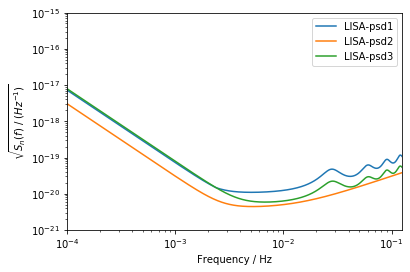

In [6]:
#绘制 频率 - sqrt(PSD) 图 
plt.figure()
plt.loglog(psd1.sample_frequencies, np.sqrt(psd1), label = 'LISA-psd1')
plt.loglog(psd2.sample_frequencies, np.sqrt(psd2), label = 'LISA-psd2')
plt.loglog(psd3.sample_frequencies, np.sqrt(psd3), label = 'LISA-psd3')
plt.xlim(1e-4, f_max)
plt.ylim(1e-21,1e-15)
plt.xlabel("Frequency / Hz")
plt.ylabel("$\sqrt{S_{n}(f) \ / \ (Hz^{-1})}$")
plt.legend()
plt.show()

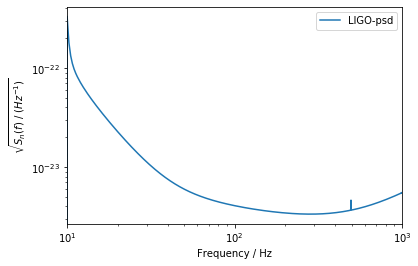

In [7]:
#绘制 频率 - sqrt(PSD) 图
plt.figure()
plt.loglog(psd4.sample_frequencies, np.sqrt(psd4), label = 'LIGO-psd')
plt.xlim(1e1,1e3)
plt.xlabel("Frequency / Hz")
plt.ylabel("$\sqrt{S_{n}(f) \ / \ (Hz^{-1})}$")
plt.legend()
plt.show()